In [18]:
from collections import deque
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [19]:
class Simulator:
    def __init__(self, rt_arrival_time, non_rt_arrival_time, rt_service_time, non_rt_service_time, batch_size,number_of_batches):
        self.rt_arrival_time = rt_arrival_time
        self.non_rt_arrival_time = non_rt_arrival_time
        self.rt_service_time = rt_service_time
        self.non_rt_service_time = non_rt_service_time
        # self.max_mc = max_mc
        self.batch_size = batch_size
        self.number_of_batches = number_of_batches

        self.RT_queue = deque([])
        self.nonRT_queue = deque([])
        self.RT_response_queue = deque([])
        self.nonRT_response_queue = deque([])
        self.batch_mean_of_RT = []
        self.batch_mean_of_nonRT = []
        self.batch_percentile_of_RT = []
        self.batch_percentile_of_nonRT = []
        self.cur_msg_arrival_time = 0
        self.mc = 0
        self.RTCL = 3
        self.nonRTCL = 5
        self.n_RT = 0
        self.n_non_RT = 0
        self.SCL = 4
        self.preempt_service_time = 0 
        self.s = 2  # 0: idle, 1: serving RT, 2: serving nonRT
        self.event_list = [[self.RTCL, 0], [self.nonRTCL, 1], [self.SCL, 2]]
        self.data = []
        # current_data = [self.mc,self.RTCL, self.nonRTCL, self.n_RT, self.n_non_RT, self.SCL, self.s, self.preempt_service_time]
        self.columns = ['MC', 'RTCL', 'nonRTCL','n_RT', 'n_nonRT', 'SCL',  's', 'Pre-empt']
        # self.data.append(current_data)
        self.df = pd.DataFrame(columns = self.columns)

    def exp_distributed_random (self,mean) :
        return -1*((mean)*(np.log(np.random.uniform())))


    def start_simulation(self):
        while self.number_of_batches >= len(self.batch_mean_of_RT) or self.number_of_batches >= len(self.batch_mean_of_nonRT) :
            self.log_state()
            if self.SCL == 0:
                event = min(self.event_list[:2])
            else : 
                event = min(self.event_list)
            self.mc = event[0] 
            if event[1] == 0:
                self.handle_RT_arrival()
            elif event[1] == 1:
                self.handle_nonRT_arrival()
            elif event[1] == 2:
                self.handle_service_completion()

        self.write_to_dataframe()

    def handle_RT_arrival(self):
        # print(type(self.RTCL))
        # self.mc = self.RTCL
        self.RT_queue.append(self.RTCL)
        self.n_RT += 1
        self.RTCL += self.exp_distributed_random(self.rt_arrival_time)
        self.event_list[0][0] = self.RTCL

        if self.n_RT == 1 :
            if self.s == 0:
                self.cur_msg_arrival_time = self.RT_queue.pop()
                self.SCL = self.mc + self.exp_distributed_random(self.rt_service_time)
                self.n_RT -= 1
                self.s = 1
            elif self.s == 2:
                # self.RT_queue.pop()
                if (self.SCL - self.mc) != 0 :
                    self.preempt_service_time =  self.SCL - self.mc
                    self.nonRT_queue.append(self.preempt_service_time+self.mc)
                    self.n_non_RT += 1

                elif self.SCL - self.mc == 0:
                    self.preempt_service_time = 0
                    self.nonRT_response_queue.append(self.mc - self.cur_msg_arrival_time)
                
                self.cur_msg_arrival_time = self.RT_queue.pop()
                self.SCL = self.mc + self.exp_distributed_random(self.rt_service_time)
                self.n_RT -= 1
                self.s = 1
            self.event_list[2][0] = self.SCL

    def handle_nonRT_arrival(self):
        self.mc = self.nonRTCL
        self.nonRT_queue.append(self.nonRTCL)
        self.n_non_RT += 1
        self.nonRTCL += self.exp_distributed_random(self.non_rt_arrival_time) 

        if len(self.nonRT_queue) == 1 and self.s == 0:
            self.cur_msg_arrival_time = self.nonRT_queue.pop()
            self.SCL = self.mc + self.exp_distributed_random(self.non_rt_service_time)
            self.s = 2
        
        self.n_non_RT -= 1
        self.event_list[1][0] = self.nonRTCL
        self.event_list[2][0] = self.SCL

    def handle_service_completion(self):
        if self.s == 1 :
            response_duration = self.mc - self.cur_msg_arrival_time
            self.RT_response_queue.append(response_duration)

            if len(self.RT_response_queue) == self.batch_size:
                # Computing statistics once a batch is complete
                average_response_time_RT = np.mean(self.RT_response_queue)
                percentile_95_response_time_RT = np.percentile(self.RT_response_queue, 95)

                self.batch_mean_of_RT.append(average_response_time_RT)
                self.batch_percentile_of_RT.append(percentile_95_response_time_RT)

                # Clearing the queue for the next batch
                self.RT_response_queue.clear()
        else:
            response_duration = self.mc - self.cur_msg_arrival_time
            self.nonRT_response_queue.append(response_duration)

            if len(self.nonRT_response_queue) == self.batch_size:
                # Computing statistics once a batch is complete
                average_response_time_nonRT = np.mean(self.nonRT_response_queue)
                percentile_95_response_time_nonRT = np.percentile(self.nonRT_response_queue, 95)

                self.batch_mean_of_nonRT.append(average_response_time_nonRT)
                self.batch_percentile_of_nonRT.append(percentile_95_response_time_nonRT)

                # Clearing the queue for the next batch
                self.nonRT_response_queue.clear()
            

        # self.mc = self.SCL
        if len(self.RT_queue) > 0:
            self.cur_msg_arrival_time = self.RT_queue.pop()
            self.SCL = self.mc + self.exp_distributed_random(self.rt_service_time)
            self.s =1
            self.n_RT -= 1

        elif len(self.RT_queue) == 0 and len(self.nonRT_queue) > 0:
            self.cur_msg_arrival_time = self.nonRT_queue.pop()
            if self.preempt_service_time > 0 :
                self.SCL = self.mc + self.preempt_service_time
                self.preempt_service_time = 0
            else:
                self.SCL = self.mc + self.exp_distributed_random(self.non_rt_service_time)
            self.s = 2
            self.n_non_RT -= 1

        else:
            self.s = 0
            self.SCL = 0
        
        self.event_list[2][0] = self.SCL

    def log_state(self):
        # if self.data and self.data[-1][0] != self.mc:
        self.data.append([self.mc, self.RTCL, self.nonRTCL, len(self.RT_queue), len(self.nonRT_queue), self.SCL, self.s, self.preempt_service_time])
        # print('MC:', self.mc, 'RTCL:', self.RTCL, 'nonRTCL:', self.nonRTCL, 'nRT:', len(self.RT_queue), 'non_nRT:', len(self.nonRT_queue),
        #       'SCL:', self.SCL, 's:', self.s, 'pre-empt:', self.preempt_service_time)

    def write_to_dataframe(self):
        self.df = pd.DataFrame(self.data, columns=self.columns)
        # print(self.df)

In [20]:
df_RT_mean_batch = pd.DataFrame(columns=['MIAT_nonRT', 'mean', '95th percentile', 'confidence interval', 'error margin'])
df_nonRT_mean_batch = pd.DataFrame(columns=['MIAT_nonRT', 'mean', '95th percentile', 'confidence interval', 'error margin'])
df_RT_percentile_batch = pd.DataFrame(columns=['MIAT_nonRT', 'mean', '95th percentile', 'confidence interval', 'error margin'])
df_nonRT_percentile_batch = pd.DataFrame(columns=['MIAT_nonRT', 'mean', '95th percentile', 'confidence interval', 'error margin'])  


In [21]:
def compute_append_rt_mean_batch(simulation, mean_interarrival_time):
    rt_avg = np.mean(simulation.batch_mean_of_RT)
    rt_95th_percentile = np.percentile(simulation.batch_mean_of_RT, 95)
    rt_conf_interval = stats.t.interval(0.95, df=len(simulation.batch_mean_of_RT)-1, loc=rt_avg, scale=stats.sem(simulation.batch_mean_of_RT))
    rt_error_margin = rt_conf_interval[1] - rt_conf_interval[0]

    return {'MIAT_nonRT': mean_interarrival_time, 'mean': rt_avg, '95th percentile': rt_95th_percentile, 'confidence interval': rt_conf_interval, 'error margin': rt_error_margin}


In [22]:
def compute_append_nonrt_mean_batch(simulation,mean_interarrival_time):
    nonrt_avg = np.mean(simulation.batch_mean_of_nonRT)
    nonrt_95th_percentile = np.percentile(simulation.batch_mean_of_nonRT, 95)
    nonrt_conf_interval = stats.t.interval(0.95, df=len(simulation.batch_mean_of_nonRT)-1, loc=nonrt_avg, scale=stats.sem(simulation.batch_mean_of_nonRT))
    nonrt_error_margin = nonrt_conf_interval[1] - nonrt_conf_interval[0]

    return {'MIAT_nonRT': mean_interarrival_time, 'mean': nonrt_avg, '95th percentile': nonrt_95th_percentile, 'confidence interval': nonrt_conf_interval, 'error margin': nonrt_error_margin}

In [23]:
def compute_append_rt_percentile_batch(simulation, mean_interarrival_time):
    rt_avg = np.mean(simulation.batch_percentile_of_RT)
    rt_95th_percentile = np.percentile(simulation.batch_percentile_of_RT, 95)
    rt_conf_interval = stats.t.interval(0.95, df=len(simulation.batch_percentile_of_RT)-1, loc=rt_avg, scale=stats.sem(simulation.batch_percentile_of_RT))
    rt_error_margin = rt_conf_interval[1] - rt_conf_interval[0]

    return {'MIAT_nonRT': mean_interarrival_time, 'mean': rt_avg, '95th percentile': rt_95th_percentile, 'confidence interval': rt_conf_interval, 'error margin': rt_error_margin}

In [24]:
def compute_append_nonrt_percentile_batch(simulation, mean_interarrival_time):
    nonrt_avg = np.mean(simulation.batch_percentile_of_nonRT)
    nonrt_95th_percentile = np.percentile(simulation.batch_percentile_of_nonRT, 95)
    nonrt_conf_interval = stats.t.interval(0.95, df=len(simulation.batch_percentile_of_nonRT)-1, loc=nonrt_avg, scale=stats.sem(simulation.batch_percentile_of_nonRT))
    nonrt_error_margin = nonrt_conf_interval[1] - nonrt_conf_interval[0]

    return {'MIAT_nonRT': mean_interarrival_time, 'mean': nonrt_avg, '95th percentile': nonrt_95th_percentile, 'confidence interval': nonrt_conf_interval, 'error margin': nonrt_error_margin}


In [25]:
rt_arrival_time = int(input("Enter the mean inter arrival time of RT messages, M_I_AT_RT: "))
rt_service_time = int(input("Enter the mean service time of RT messages, M_ST_RT: "))
non_rt_service_time = int(input("Enter the mean service time of non RT messages, M_ST_nonRT: "))
number_of_batches = int(input("Enter the number of batches, m: "))
batch_size = int(input("Enter the batch size, b: "))
# rt_arrival_time = 7
# rt_service_time = 2
# non_rt_service_time = 4
# number_of_batches = 51
# batch_size =1000
non_rt_arrival_time_sequence = [10,15,20,25,30,35,40]

print('Entered mean inter arrival time of RT messages, M_I_AT_RT:', rt_arrival_time)
print("Entered mean service time of RT messages, M_ST_RT: ",rt_service_time)
print("Entered mean service time of non RT messages, M_ST_nonRT: ",non_rt_service_time)
print("Entered number of batches, m: ",number_of_batches)
print("Enter batch size, b: ",batch_size)

Entered mean inter arrival time of RT messages, M_I_AT_RT: 7
Entered mean service time of RT messages, M_ST_RT:  2
Entered mean service time of non RT messages, M_ST_nonRT:  4
Entered number of batches, m:  51
Enter batch size, b:  1000


In [26]:
for nonRT_arrival_time in non_rt_arrival_time_sequence:
    simulator = Simulator(rt_arrival_time, nonRT_arrival_time, rt_service_time, non_rt_service_time, batch_size,number_of_batches)
    simulator.start_simulation()

    simulator.batch_mean_of_RT = simulator.batch_mean_of_RT[1:51]
    simulator.batch_percentile_of_RT = simulator.batch_percentile_of_RT[1:51]
    simulator.batch_mean_of_nonRT = simulator.batch_mean_of_nonRT[1:51]
    simulator.batch_percentile_of_nonRT = simulator.batch_percentile_of_nonRT[1:51]

    # Calculation of batch mean and batch percentile
    new_row_RT_mean_batch = compute_append_rt_mean_batch(simulator, nonRT_arrival_time)
    df_RT_mean_batch = pd.concat([df_RT_mean_batch, pd.DataFrame([new_row_RT_mean_batch])], ignore_index=True)
    new_row_nonRT_mean_batch = compute_append_nonrt_mean_batch(simulator, nonRT_arrival_time)
    df_nonRT_mean_batch = pd.concat([df_nonRT_mean_batch, pd.DataFrame([new_row_nonRT_mean_batch])], ignore_index=True)
    new_row_df_RT_percentile_batch = compute_append_rt_percentile_batch(simulator, nonRT_arrival_time)
    df_RT_percentile_batch = pd.concat([df_RT_percentile_batch, pd.DataFrame([new_row_df_RT_percentile_batch])], ignore_index=True)
    new_row_df_nonRT_percentile_batch = compute_append_nonrt_percentile_batch(simulator, nonRT_arrival_time)
    df_nonRT_percentile_batch = pd.concat([df_nonRT_percentile_batch, pd.DataFrame([new_row_df_nonRT_percentile_batch])], ignore_index=True)

In [27]:
print("RT Message Statistics - Mean Batches:")
print(df_RT_mean_batch)

RT Message Statistics - Mean Batches:
  MIAT_nonRT      mean  95th percentile  \
0         10  2.822462         3.023114   
1         15  2.779803         2.993671   
2         20  2.795498         3.090144   
3         25  2.822620         3.067144   
4         30  2.868881         3.109181   
5         35  2.799131         3.009252   
6         40  2.790644         3.016033   

                        confidence interval  error margin  
0    (2.77898493552375, 2.8659382811688086)      0.086953  
1  (2.7453644801429147, 2.8142406786978618)      0.068876  
2   (2.7469036414474393, 2.844092638357076)      0.097189  
3  (2.7808273089244504, 2.8644121229817405)      0.083585  
4    (2.82772202437825, 2.9100396199081047)      0.082318  
5  (2.7561115449473585, 2.8421502179725775)      0.086039  
6  (2.7458708747361324, 2.8354161626311134)      0.089545  


In [28]:
print("NonRT Message Statistics - Mean Batches:")
print(df_nonRT_mean_batch)

NonRT Message Statistics - Mean Batches:
  MIAT_nonRT      mean  95th percentile  \
0         10  8.635032        10.068412   
1         15  5.747448         6.505309   
2         20  4.928011         5.409616   
3         25  4.575588         5.047704   
4         30  4.321686         4.790233   
5         35  4.095464         4.543460   
6         40  4.024959         4.411150   

                        confidence interval  error margin  
0      (8.3966719961544, 8.873391798360167)      0.476720  
1     (5.61626830039178, 5.878628348345903)      0.262360  
2    (4.833879672982261, 5.022142438404338)      0.188263  
3    (4.494282925023255, 4.656892880622192)      0.162610  
4    (4.244930672396088, 4.398442063522155)      0.153511  
5   (4.029822454946803, 4.1611054611489635)      0.131283  
6  (3.9638762864002315, 4.0860413078742885)      0.122165  


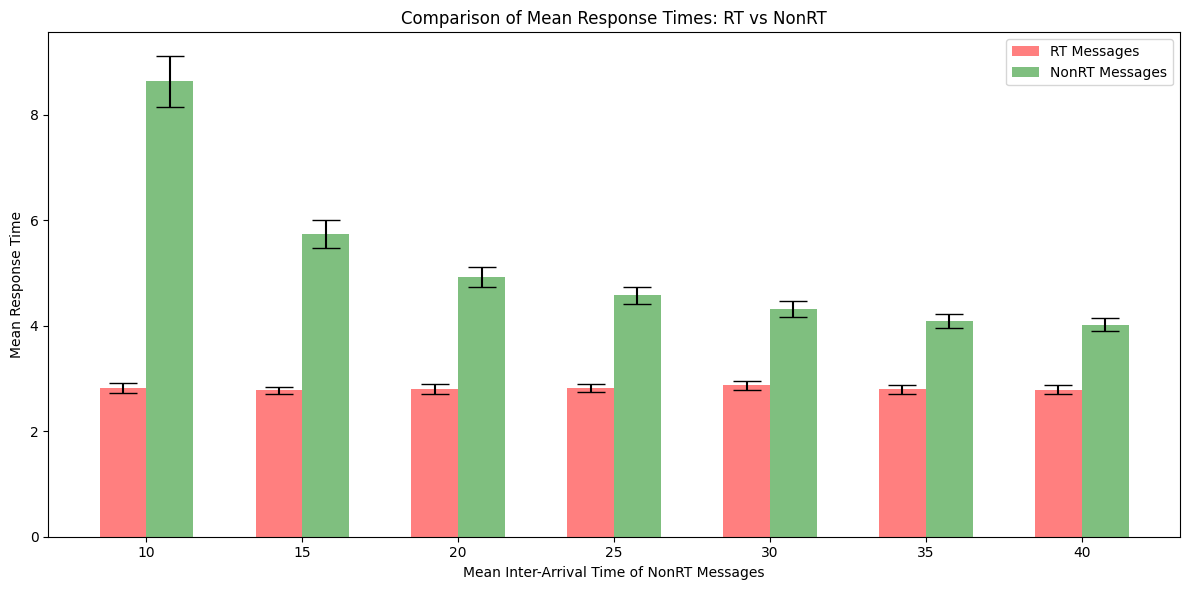

In [33]:
# Set up the plot for Mean Response Time comparison
fig, ax = plt.subplots(figsize=(12, 6))
index_positions = np.arange(len(non_rt_arrival_time_sequence))
bar_width = 0.3
color_rt = 'red'
color_nonrt = 'green'
bars_rt = ax.bar(index_positions - bar_width/2, df_RT_mean_batch['mean'], bar_width, yerr=df_RT_mean_batch['error margin'], alpha=0.5, ecolor='black', capsize=10, label='RT Messages',color = color_rt)
bars_non_rt = ax.bar(index_positions + bar_width/2, df_nonRT_mean_batch['mean'], bar_width, yerr=df_nonRT_mean_batch['error margin'], alpha=0.5, ecolor='black', capsize=10, label='NonRT Messages', color = color_nonrt)

# Setting labels and titles
ax.set_ylabel('Mean Response Time')
ax.set_xlabel('Mean Inter-Arrival Time of NonRT Messages')
ax.set_title('Comparison of Mean Response Times: RT vs NonRT')
ax.set_xticks(index_positions)
ax.set_xticklabels(non_rt_arrival_time_sequence)
ax.legend()

# Adjust layout and display the plot
fig.tight_layout()
plt.show()

In [30]:
print("Percentile Batch Statistics - RT Messages:")
print(df_RT_percentile_batch)

Percentile Batch Statistics - RT Messages:
  MIAT_nonRT      mean  95th percentile  \
0         10  8.541892         9.360687   
1         15  8.262171         8.942944   
2         20  8.416934         9.634939   
3         25  8.511546         9.595357   
4         30  8.577169         9.673259   
5         35  8.384921         9.234019   
6         40  8.475513         9.334389   

                      confidence interval  error margin  
0  (8.380392623379459, 8.703390581712528)      0.322998  
1  (8.135096783338119, 8.389245055394094)      0.254148  
2  (8.223536356067754, 8.610330931028102)      0.386795  
3   (8.334899229114987, 8.68819279642745)      0.353294  
4  (8.409252169261919, 8.745085627890333)      0.335833  
5  (8.217999393995813, 8.551843458784555)      0.333844  
6  (8.282132828101993, 8.668893950295779)      0.386761  


In [31]:
print("Percentile Batch Statistics - NonRT Messages:")
print(df_nonRT_percentile_batch)

Percentile Batch Statistics - NonRT Messages:
  MIAT_nonRT       mean  95th percentile  \
0         10  33.383445        41.315144   
1         15  20.797900        26.042329   
2         20  17.017382        19.926564   
3         25  15.585330        17.852424   
4         30  14.686195        16.561220   
5         35  13.758480        15.333053   
6         40  13.523480        15.199365   

                        confidence interval  error margin  
0    (32.00292151417892, 34.76396761430816)      2.761046  
1   (20.038413750835133, 21.55738615370128)      1.518972  
2  (16.559505965398913, 17.475258599405265)      0.915753  
3  (15.212682504799231, 15.957977900110867)      0.745295  
4  (14.318857767464031, 15.053532002543754)      0.734674  
5  (13.462188970093868, 14.054771302537324)      0.592582  
6    (13.225201301674227, 13.8217579710356)      0.596557  


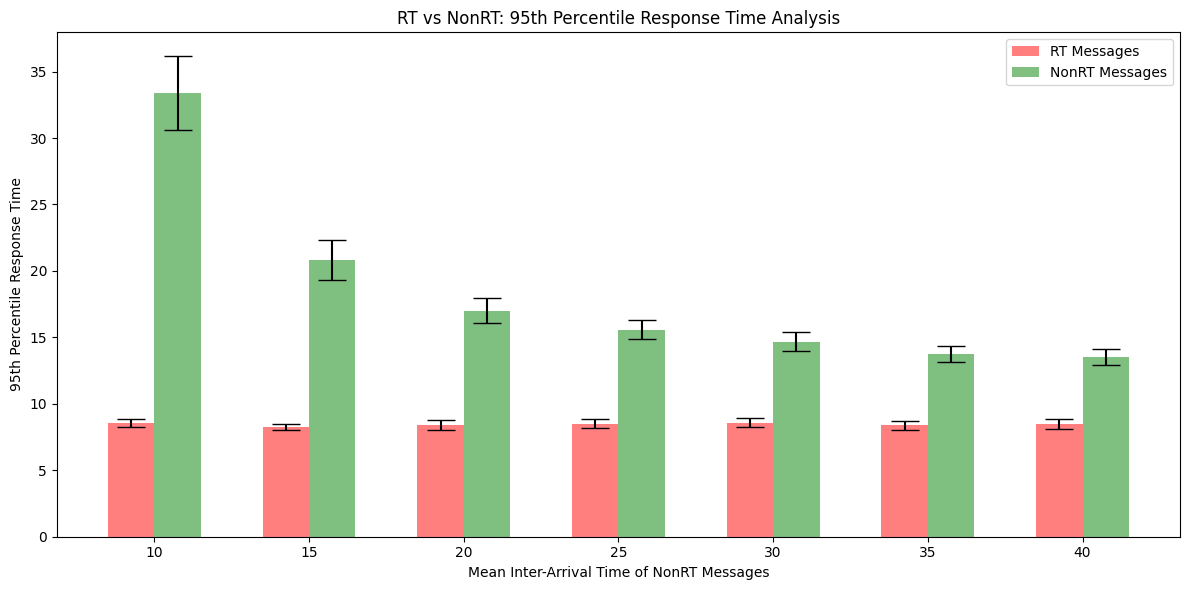

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the bars for RT and nonRT message statistics
color_rt = 'red'
color_nonrt = 'green'
bars_rt_percentile = ax.bar(index_positions - bar_width/2, df_RT_percentile_batch['mean'], bar_width, yerr=df_RT_percentile_batch['error margin'], alpha=0.5, ecolor='black', capsize=10, label='RT Messages', color = color_rt)
bars_non_rt_percentile = ax.bar(index_positions + bar_width/2, df_nonRT_percentile_batch['mean'], bar_width, yerr=df_nonRT_percentile_batch['error margin'], alpha=0.5, ecolor='black', capsize=10, label='NonRT Messages',color = color_nonrt)

# Configuring plot settings
ax.set_ylabel('95th Percentile Response Time')
ax.set_xlabel('Mean Inter-Arrival Time of NonRT Messages')
ax.set_title('RT vs NonRT: 95th Percentile Response Time Analysis')
ax.set_xticks(index_positions)
ax.set_xticklabels(non_rt_arrival_time_sequence)
ax.legend()

# Final layout adjustment and plot display
fig.tight_layout()
plt.show()